## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import seaborn as sns
from itertools import chain
import matplotlib.image as img
import pydicom

#scaling the data before feeding the model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
import sklearn as skl


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam


from keras.applications.resnet import ResNet50 


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(30)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
20618,00005520_002.png,No Finding,2,5520,42,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_003/images/00005520_002.png
84080,00020673_002.png,Infiltration,2,20673,31,F,AP,3056,2544,0.139000,0.139000,NaN,/data/images_009/images/00020673_002.png
48614,00012320_003.png,No Finding,3,12320,68,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_006/images/00012320_003.png
106440,00028677_001.png,Emphysema|Infiltration|Pneumothorax,1,28677,49,M,AP,3056,2544,0.139000,0.139000,NaN,/data/images_012/images/00028677_001.png
5868,00001582_009.png,Cardiomegaly|Effusion|Infiltration,9,1582,30,F,AP,2500,2048,0.171000,0.171000,NaN,/data/images_002/images/00001582_009.png
66012,00016305_002.png,Atelectasis|Pneumothorax,2,16305,47,F,AP,2500,2048,0.168000,0.168000,NaN,/data/images_008/images/00016305_002.png
71017,00017514_004.png,No Finding,4,17514,63,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_008/images/00017514_004.png
29385,00007647_000.png,No Finding,0,7647,43,F,PA,2500,2048,0.168000,0.168000,NaN,/data/images_004/images/00007647_000.png
19839,00005288_000.png,Cardiomegaly|Effusion,0,5288,41,M,PA,2500,2048,0.171000,0.171000,NaN,/data/images_003/images/00005288_000.png
104154,00027817_002.png,Pneumothorax,2,27817,43,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_011/images/00027817_002.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

#clean up some variables

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(30)





# Todo

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
34729,00009153_000.png,Infiltration,0,9153,28,F,PA,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
51538,00013015_002.png,No Finding,2,13015,80,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
48422,00012278_000.png,No Finding,0,12278,67,F,PA,2992,2597,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
48102,00012178_004.png,No Finding,4,12178,28,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
54733,00013685_036.png,Infiltration,36,13685,49,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18065,00004833_047.png,Atelectasis|Consolidation|Effusion|Pleural_Thi...,47,4833,28,M,AP,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45608,00011695_001.png,No Finding,1,11695,50,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
104861,00028115_000.png,Effusion|Infiltration|Mass,0,28115,40,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
48153,00012201_000.png,No Finding,0,12201,46,F,PA,2758,2453,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
67373,00016634_003.png,No Finding,3,16634,55,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
#given the large dataset, drop these 27 cases and limit our system to age up to 95


#define a new dataframe
data = pd.DataFrame(all_xray_df[all_xray_df['Patient Age']<96])
#gotta use pd.DataFrame rather than the subset/slice
#also could use df.assign()

#recode Patient Gender to a binary


#data.loc[data['Patient Gender']=='F','Female']=1
#data.loc[data['Patient Gender']=='M','Female']=0
# returns this warning:
#/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
#A value is trying to be set on a copy of a slice from a DataFrame.
#Try using .loc[row_indexer,col_indexer] = value instead
#  See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#a better way to recode values into a new column
data['Female']=data['Patient Gender'].map(lambda gender: 1 if gender =='F' else 0)


#data.sample(10)


#data['Comorbidities'] = data['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax'].sum(axis=1).map(lambda sums: 1 if sums >0 else 0)
#this doesn't work.

#data['Comorbidities'] = pd.DataFrame(data,columns=['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']).sum(axis=1).map(lambda sums: 1 if sums >0 else 0)
#has to operate on a dataframe first and loses columns in the process

#use df.apply()?  df.column?  No, use .loc
data['Comorbidities'] = data.loc[:,['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']].sum(axis=1).map(lambda sums: 1 if sums >0 else 0)



#VALS, COUNTS = np.unique(comonum, return_counts=True)

data.sample(10)




,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Female,Comorbidities
50651,00012834_056.png,Atelectasis|Consolidation|Effusion|Infiltration,56,12834,33,M,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
71985,00017731_004.png,No Finding,4,17731,39,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
74775,00018360_037.png,Infiltration|Mass,37,18360,62,M,AP,3056,2544,0.139,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1
77907,00019133_000.png,No Finding,0,19133,44,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0
74532,00018293_001.png,No Finding,1,18293,62,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
2434,00000627_029.png,Consolidation,29,627,59,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
55984,00013993_040.png,No Finding,40,13993,42,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
33611,00008814_006.png,Pneumothorax,6,8814,31,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
60676,00014977_000.png,No Finding,0,14977,56,F,PA,2850,2453,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0
45606,00011694_000.png,No Finding,0,11694,37,F,PA,2590,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0


## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

##


train_df, valid_df = skl.train_test_split(d, 
                                   test_size = 0.2, 
                                   stratify = d['Pneumothorax'])




112104 images, 1430 have the diagnosis of pneumonia. Using the 70%-10%-20% split of training, validation, and testing sets,

1001 cases for training 143 cases for validation during training 286 cases for testing the model


## Create your training and testing data:

In [5]:
#Learned that classes need to defined as str variables.
data['pneumonia_class'] = data.loc[:,'Pneumonia'].astype(str) 

#data.info()  #check that the Pneumonia_class is 

In [6]:
#def create_splits(vargs):  # no need to do this in a function??
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    
cases = data[data['Pneumonia']==1]
controls=data[data['Pneumonia']==0]
    
    
    #Split the cases
train_df_cases, valid_df_cases = skl.model_selection.train_test_split(cases, 
                                   test_size = 0.2, 
                                   stratify = cases['Comorbidities'])

print(train_df_cases.shape[0])
print(valid_df_cases.shape[0])

    #Split the controls
    
train_df_controls, valid_df_controls = skl.model_selection.train_test_split(controls, 
                                   train_size = 1144, test_size=286*4,
                                   stratify = controls['Comorbidities'])

print(train_df_controls.shape[0])
print(valid_df_controls.shape[0])


train_data=train_df_cases.append(train_df_controls).sample(frac=1).reset_index(drop=True)   # extra shuffling for training
val_data = valid_df_cases.append(valid_df_controls).sample(frac=1).reset_index(drop=True)   # I guess we don't actually need to do this

print(train_data.shape[0])
print(val_data.shape[0])



    #return train_data, val_data

1144
286
1144
1144
2288
1430


# sizes:

Training data = 1144 cases + 1144 controls = 2288
Validation data=286 cases + 1144 controls = 1430




# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [28]:
from keras.preprocessing.image import ImageDataGenerator

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo

    train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                                  zca_whitening=True,
                                  zca_epsilon=1e-3
                                  
                                  
                                  )

    valid_idg = ImageDataGenerator(rescale=1. / 255.0)
    
         
    
    return train_idg, valid_idg

def make_train_gen():
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                          directory=None, 
                                          x_col = 'path' ,
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224),
                                          batch_size = 9
                                          )
     # Todo

    return train_gen


def make_val_gen():
    
    val_gen = val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                              target_size = (224,224), 
                                              batch_size = 9) 
    
    # Todo
    return val_gen


#again, not sure why these are in functions.

train_idg, val_idg = my_image_augmentation()
train_gen=make_train_gen()
val_gen=make_val_gen()

Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [29]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

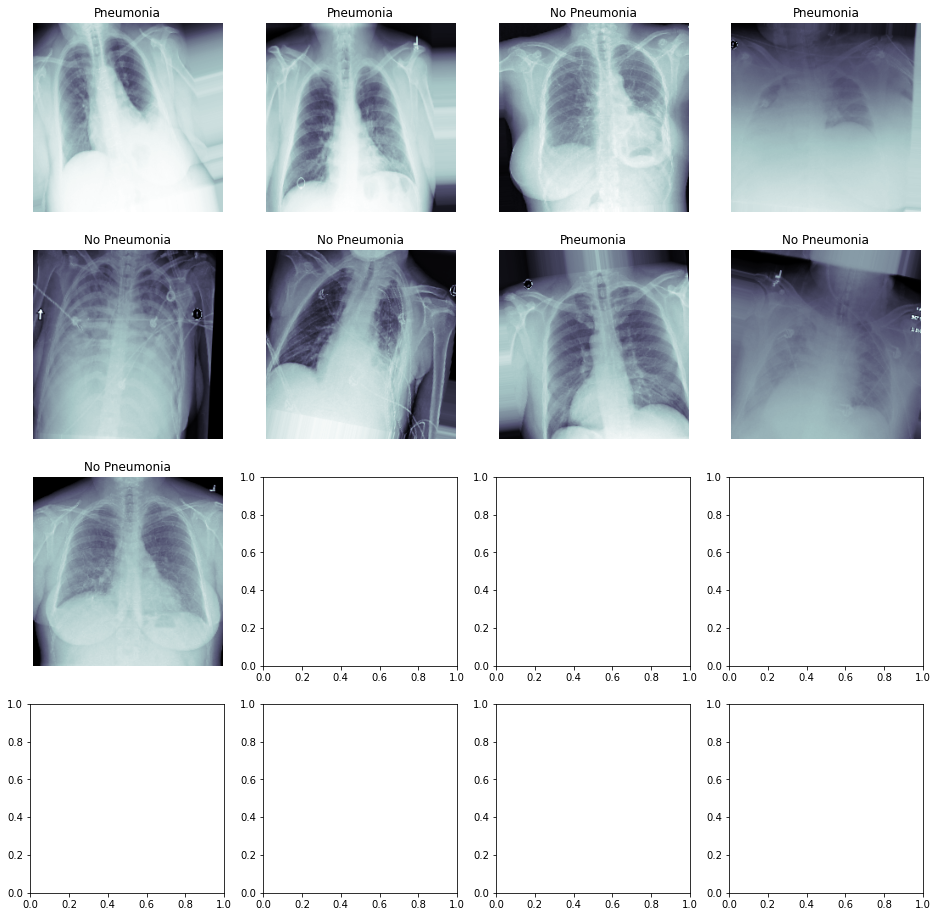

In [30]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [36]:
#from keras.applications.resnet import ResNet50 

rmodel = ResNet50()
rmodel.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [41]:
#model = VGG16(include_top=True, weights='imagenet')

from keras.models import Model

transfer_layer = rmodel.get_layer('conv5_block3_out')

rmodel_1 = Model(inputs = rmodel.input, outputs = transfer_layer.output)


#res


for layer in rmodel_1.layers[:]:
    layer.trainable = False

rmodel_1.summary()



Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [55]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer

mymodel = Sequential(rmodel_1)
mymodel.add(Flatten())
mymodel.add(Dropout(0.4))
mymodel.add(Dense(1024, activation='relu'))
mymodel.add(Dropout(0.4))
mymodel.add(Dense(512, activation='relu'))
mymodel.add(Dropout(0.5))
mymodel.add(Dense(256, activation='relu'))
mymodel.add(Dense(1, activation='sigmoid'))


optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

mymodel.compile(optimizer=optimizer, loss=loss, metrics=metrics)

mymodel.summary()



#def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatten, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
   # return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

TypeError: The added layer must be an instance of class Layer. Found: <keras.engine.training.Model object at 0x7f02581e1f50>

In [ ]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

import tensorflow.keras.callbacks

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                             mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [ ]:
## train your model

# Todo

history = mymodel.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 1, 
                           callbacks = callbacks_list)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [ ]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)